In [8]:
%matplotlib inline
import tensorflow as tf 

from tensorflow.python.keras.applications.vgg19 import VGG19
import numpy as np
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
from PIL import Image
lr = 3.0
size = 224
iterations = 3000
style_wt = 1e5
content_wt = 1.0
content_image_path = "/content/drive/My Drive/dp.jpg"
style_image_path = "/content/drive/My Drive/styleranvow.jpg"
style_layer_wts = [1.0, 0.5, 0.1, 0.1, 0.5]

In [9]:
model  = VGG19(
    include_top = False,
    weights='imagenet',
    input_shape=(size, size, 3)
)

model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
#def image_and_process(image_path):
#  img = load_img(image_path)
#  img = preprocess_input(img)
#  img = img_to_array(img)
# img = np.expand_dims(img, axis= 0)
#  return img
def image_process(image_path):
  img = tf.keras.preprocessing.image.load_img(image_path, target_size=(size, size))
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return np.expand_dims(img, axis = 0)

In [11]:
def deprocess(x):
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:,:,::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

def image_display(image):
  if len(image.shape) == 4:
    image = image[0,:,:,:]

  img = deprocess(image)

 # plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  plt.show()

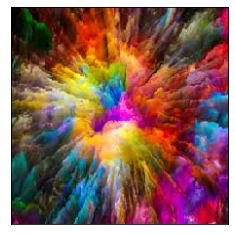

In [12]:
image_display(image_process(style_image_path))

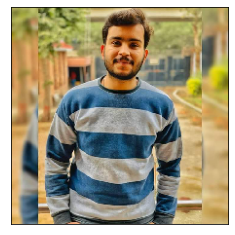

In [13]:
image_display(image_process(content_image_path))

In [14]:
content_layer = 'block4_conv2'

content_model = tf.keras.models.Model(
    inputs=model.input,
    outputs = model.get_layer(content_layer).output 
)

In [15]:
style_layers = [
                'block1_conv1' , 'block1_conv2',
                'block2_conv1' , 'block2_conv2',
                'block3_conv1'
]

style_models = [
               tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer).output)
               for layer in style_layers
]

In [16]:
x = image_process(style_image_path)

temp_layer = 'block1_conv1'
temp_model = tf.keras.models.Model(
    model.input,
    model.get_layer(temp_layer).output
)

out = temp_model.predict(x)[0]
print(out.shape)

(224, 224, 64)


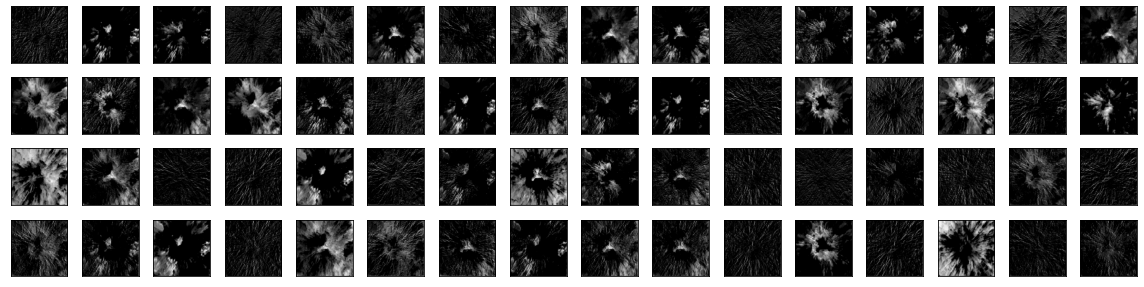

In [17]:
plt.figure(figsize=(16, 8))
for i in range (0, 64):
  plt.subplot(8, 16, i + 1)
  plt.imshow(out[:,:,i], cmap='gray')
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()
plt.show()

In [18]:
def content_cost(content_img, generated_img):
  a_c = content_model(content_img)
  a_g = content_model(generated_img)

  cost = tf.reduce_mean(tf.square(a_c - a_g))
  return cost

In [19]:
def gram_matrix(M):
  num_channels = tf.shape(M)[-1]
  M = tf.reshape(M, shape=(-1, num_channels))
  n = tf.shape(M)[0]
  G = tf.matmul(tf.transpose(M), M)
  return G / tf.cast(n, dtype=tf.float32)

In [20]:
def style_cost(style_img, generated_img):
  total_cost = 0
  for i,  style_model in enumerate(style_models):
    a_s = style_model(style_img)
    a_g = style_model(generated_img)
    GS = gram_matrix(a_s)
    GG = gram_matrix(a_g)
    current_cost = style_layer_wts[i] * tf.reduce_mean(tf.square(GS - GG))
    total_cost += current_cost
  total_cost /= (size * size * len(style_models))
  return style_cost

In [30]:
import time

generated_images = []

def training_loop(content_image_path, style_image_path, iterations = 20, a = 10., b = 20.):
    # initialise
    content_image_preprocessed = image_process(content_image_path)
    style_image_preprocessed = image_process(style_image_path)
    generated = tf.contrib.eager.Variable(content, dtype = tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate = 7.)
    
    best_cost = 1e12+0.1
    best_image = None
    
    start_time = time.time()
    
    for i in range(iterations):
        
        with tf.GradientTape() as tape:
            J_content = content_cost(content_img, generated_img)
            J_style = style_cost(style, generated_img)
            J_total = a * J_content + b * J_style
        
        grads = tape.gradient(J_total, generated)
        opt.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
        
        if i % int(iterations/10) == 0:
            time_taken = time.time() - start_time
            print('Cost at {}: {}. Time elapsed: {}'.format(i, J_total, time_taken))
            generated_images.append(generated.numpy())
        
    return best_image

In [31]:
final = training_loop(content_image_path, style_image_path)

AttributeError: ignored